# 0 Setup

## 0.1 Installing & importing required Python libraries

In [63]:
%pip install pandas
%pip install pyflightdata
%pip install matplotlib
%pip install tqdm
%pip install seaborn
%pip install logging
%pip install cartopy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for logging: filename=logging-0.4.9.6-py3-none-any.whl size=29515 sha256=fa17298c6aa4859111c76e01132bfa18849f6e93795927b23a208315db850294
  Stored in directory: /Users/thealteredmg/Library/Caches/pip/wheels/30/80/e6/0a01576c333eb17cb6f3ad46889726bbb140ff661beae5ad2a
Successfully built logging
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 6.8 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 9.1 MB/s eta 0:00:

In [100]:
import pandas as pd
import tqdm as tqdm
from pyflightdata import FlightData
import matplotlib.pyplot as plt
import numpy as np


## 0.2 Loading & inspecting data

In [65]:

# Load the data
file_path = 'data/IVDA_A3_2024_Company_FlightData.csv'  # Replace with your actual file path
data = pd.read_csv(file_path, sep=';')

# Investigating data structure & understand volume
display(data.head())
print(f'Size of data: {len(data)} rows')


,Flight number,Aircraft type,Departure,Destination,Segments,Service class,Total Distance [km],CO2 RFI 2 + emissions jet fuel production 15.2% [t],Department
0,"6,00E+32",NaN,NaN,NaN,1.0,Y,913.0,0.1045576,HR
1,"6,00E+32",NaN,NaN,NaN,1.0,B,913.0,0.150562944,Marketing
2,2I3116,NaN,IQT,TPP,1.0,Y,504.0,0.0916184,Operations
3,2I3116,NaN,IQT,TPP,1.0,Y,504.0,0.0916184,IT
4,2I3134,NaN,PCL,LIM,2.0,Y,1082.0,0.1715776,Finance


Size of data: 7464 rows


In [68]:
# Understand how many NaN-values we are facing in "Departure" & "Destination"
print(data[['Departure', 'Destination']].isna().sum())

Departure      3204
Destination    3204
dtype: int64


In [66]:
print(f"{len(data['Flight number'].unique())} unique flight numbers in dataset.")

2299 unique flight numbers in dataset.


## 0.3 Split data into 2 datasets ("data_trips" & "data_flights")

In [70]:
# Setup of a "data_trips" Dataframe, containing all individual trips
data_trips = data[["Flight number", "Aircraft type", "Segments", "Service class", "Department"]]

# Setup of a "data_flights" Dataframe, containing all flights
data_flights_temp = data[["Flight number", "Departure", "Destination", "Total Distance [km]", "CO2 RFI 2 + emissions jet fuel production 15.2% [t]"]]
data_flights = data_flights_temp.drop_duplicates(subset='Flight number', keep='last') # As the whole dataset only has about 2k unique flight numbers, the rest can be dropped.


# 1 Reduction of missing data of departure and destination - 4 points

## 1.1 Understand volume of NaN-values and how to find the most recent flight information

In [72]:
# Check for NaN-values in "Destination" and "Departure" for unique flight-numbers
missing_values = data_flights[['Departure', 'Destination']].isna().sum()
print(missing_values)


Departure      1029
Destination    1029
dtype: int64


In [77]:
# Setup of pyflightdata API
fd = FlightData()

# Check layout of API-response (example)
flight = fd.get_history_by_flight_number('LX1266')

print(flight)
print(flight[0])

print(flight[0]["airport"]["origin"]["code"]["iata"])
print(flight[0]["airport"]["destination"]["code"]["iata"])

[{'identification': {'number': {'default': 'LX1266', 'alternative': 'BT1266'}, 'callsign': 'None', 'codeshare': 'None'}, 'status': {'live': False, 'text': 'Scheduled', 'estimated': 'None', 'ambiguous': False, 'generic': {'status': {'text': 'scheduled', 'type': 'departure', 'color': 'gray', 'diverted': 'None'}, 'eventTime': {'utc': 'None', 'local': 'None'}}}, 'aircraft': {'model': {'code': '223', 'text': 'None'}, 'registration': 'None', 'serialNo': 'None', 'age': 'None', 'restricted': 'None', 'availability': {'serialNo': 'None', 'age': 'None'}}, 'owner': 'None', 'airline': {'name': 'Swiss', 'code': {'iata': 'LX', 'icao': 'SWR'}}, 'airport': {'origin': {'name': 'Zurich Airport', 'code': {'iata': 'ZRH', 'icao': 'LSZH'}, 'position': {'latitude': 47.464722, 'longitude': 8.549167, 'country': {'name': 'Switzerland', 'code': 'CH'}, 'region': {'city': 'Zurich'}}, 'timezone': {'name': 'Europe/Zurich', 'offset': 3600, 'abbr': 'CET', 'abbrName': 'Central European Time', 'isDst': False}, 'visible':

In [79]:
most_recent_departure = None
most_recent_index = -1

# Iterate over the API response to find the flight with the most recent departure time
for index, flight in enumerate(flight):
    # Get the departure time in milliseconds
    departure_time_millis = flight['time']['scheduled']['departure_millis']
    
    # Check if this is the most recent departure
    if most_recent_departure is None or departure_time_millis > most_recent_departure:
        most_recent_departure = departure_time_millis
        most_recent_index = index

# Output the index and departure time of the most recent flight
print(f"Most recent departure is at index: {most_recent_index}, Departure time (milliseconds): {most_recent_departure}")


Most recent departure is at index: 0, Departure time (milliseconds): 1730268300000


## 1.2 Retrieve missing "Departure" and "Destination" values

In [83]:

def retrieve_missing_info(row):
    if (pd.isnull(row['Departure']) or pd.isnull(row['Destination'])):
        try:
            if len(fd.get_flights(row['Flight number'])) > 0:
                flight_info = fd.get_history_by_flight_number(row['Flight number'])  # Retrieve flight information based on past flights.
                if len(flight_info) > 0:
                    row['Departure'] = flight_info[0]["airport"]["origin"]["code"]["iata"] # Get most recent departure IATA-code
                    row['Destination'] = flight_info[0]["airport"]["destination"]["code"]["iata"] # Get most recent destination IATA-code
                    print(f"{row.name}/{len(data)}")
        except Exception as e:
            print(f"Error retrieving departure for flight {row['Flight number']}: {e}")
    return row

In [84]:
t1_data_flights = data_flights.apply(retrieve_missing_info, axis=1)

48/7464
54/7464
60/7464
61/7464
63/7464
65/7464
69/7464
HTML code 402 - Retry in 10 seconds...
72/7464
78/7464
79/7464
88/7464
89/7464
HTML code 402 - Retry in 10 seconds...
91/7464
95/7464
98/7464
HTML code 402 - Retry in 10 seconds...
102/7464
104/7464
HTML code 402 - Retry in 10 seconds...
116/7464
120/7464
153/7464
HTML code 402 - Retry in 10 seconds...
156/7464
159/7464
160/7464
HTML code 402 - Retry in 10 seconds...
202/7464
203/7464
204/7464
HTML code 402 - Retry in 10 seconds...
231/7464
241/7464
HTML code 402 - Retry in 10 seconds...
256/7464
269/7464
HTML code 402 - Retry in 10 seconds...
292/7464
293/7464
312/7464
321/7464
HTML code 402 - Retry in 10 seconds...
324/7464
339/7464
351/7464
357/7464
360/7464
HTML code 402 - Retry in 10 seconds...
367/7464
372/7464
HTML code 402 - Retry in 10 seconds...
377/7464
387/7464
HTML code 402 - Retry in 10 seconds...
HTML code 402 - Retry in 10 seconds...
414/7464
416/7464
417/7464
HTML code 402 - Retry in 10 seconds...
423/7464
424/746

Departure      417
Destination    417
dtype: int64


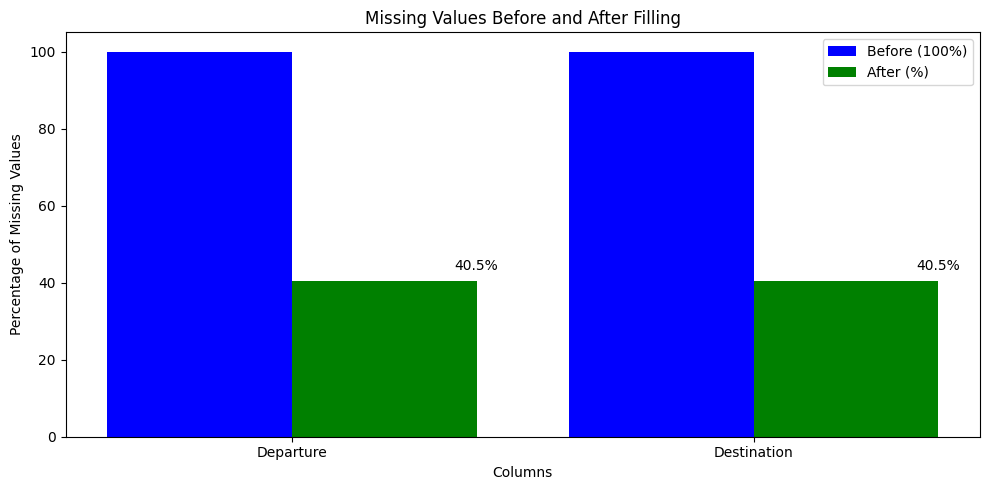

In [102]:

# Plot before filling missing values
missing_before = missing_values

# After filling missing values
missing_after = t1_data_flights[['Departure', 'Destination']].isnull().sum()

print(missing_after)

# Plotting as bar chart
labels = ['Departure', 'Destination']
before_counts = [missing_before['Departure'], missing_before['Destination']]
after_counts = [missing_after['Departure'], missing_after['Destination']]

# Calculate percentage of the After counts relative to Before counts
percentage_after = [(count / before) * 100 for count, before in zip(after_counts, before_counts)]

x = np.arange(len(labels))

# Plotting the bar chart
plt.figure(figsize=(10, 5))  # Adjusting figure size
plt.bar(x, [100] * len(before_counts), width=0.4, label='Before (100%)', color='blue', align='center')  # 100% for Before
plt.bar(x + 0.4, percentage_after, width=0.4, label='After (%)', color='green', align='center')

plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values')
plt.title('Missing Values Before and After Filling')
plt.xticks(x + 0.2, labels)
plt.legend()

# Adding value annotations on the "After" bars
for i in range(len(percentage_after)):
    plt.text(i + 0.6, percentage_after[i] + 2, f'{percentage_after[i]:.1f}%', 
             ha='center', va='bottom', color='black', fontsize=10)

plt.tight_layout()  # Adjust layout to make it look better
plt.show()




Before: 1029
After: 417

## 1.3 Clean up after data retrieval

In [103]:
# Drop rows containing "NaN" in data_flights Dataframe
columns_to_check = ['Departure', 'Destination']
t1_data_flights_cleaned = data_flights.dropna(subset=columns_to_check)

print(f"{len(t1_data_flights_cleaned)} unqiue flights remain after cleanup.")

# Save progress to file
t1_data_flights_cleaned.to_csv('data/t1_FlightData.csv', index=False, sep=';')
data_trips.to_csv('data/t1_TripData.csv', index=False, sep=';')

1882 unqiue flights remain after cleanup.


## 1.4 Reasoning

Initially it was observed through ```print(len(data['Flight number'].unique()))``` that there are indeed only 2299 unique flight numbers in this dataset. As the flight number acts as the unique identifier for a flight, the dataset could be split into two, a trips dataset ```data_trips``` and a flights dataset ```data_flights```. From the latter, all duplicates could be dropped, which significantly reduced the effort required to find the missing departure and destination information (shown as "NaN" in pandas).

The Python library ```pyflightdata```, more specifically, its function ```get_history_by_flight_number(flight_number)``` was used to fetch the missing departure and destination data. ```get_history_by_flight_number(flight_number)``` takes a flight number and returns a list of occurrences of this flight, including IATA-codes.

>The function ```get_history_by_flight_number(flight_number)``` returns numerous entries for the same flight ID's with sometimes different destination/departure codes, the first entry to the list was deemed appropriate as the most accurate representation of correct data as it is the most recent (see ch. 1.1 for proof).

As can be seen in the above bar-chart, the developed function ```retrieve_missing_info()``` was used to iterate over the whole dataset and fill the missing values. The missing data could be significantly reduced from 1029 flights with NaN-values to 417 (for both departure and destination).

For some flights, the ``pyflightapi`` returns a HTTP-402 error indicating that a paid account is required to fetch requested information. To further reduce the amount of flights with NaN-values, such an account would be required. This measure was not taken for this task, and therefore some unique flight-numbers with NaN-values remain. These rows were dropped (see ch. 1.3) to not further interfere with upcoming tasks.

# 2 Airport code errors - 1 point

In [104]:
# Load airport data
data_airports = pd.read_csv('data/iata-icao.csv')

# Load data_flights dataset as pandas df
data_flights = pd.read_csv('data/t1_FlightData.csv', sep=';')

## 2.1 Find airport code errors

In [105]:
# Convert the valid IATA codes to a set for quick lookup
valid_iata_set = set(data_airports['iata'].str.upper())  # Convert to uppercase for consistency

# Add "IATA-Error" column for tracking
data_flights["IATA-Error"] = 0

# Function to check and correct IATA codes
def check_airport_codes(row):
    if row['Departure'] not in valid_iata_set:
        row['Departure'] = None
        row["IATA-Error"] = 1
    if row['Destination'] not in valid_iata_set:
        row['Destination'] = None
        row["IATA-Error"] = 1
    return row

error_data_before = data_flights.apply(check_airport_codes, axis=1)


## 2.2 Resolving IATA-Errors

In [92]:
def solve_iata_error(row):
    if row['IATA-Error'] == 1:
        try:
            if len(fd.get_flights(row['Flight number'])) > 0:
                flight_info = fd.get_history_by_flight_number(row['Flight number'])  # Retrieve flight information based on past flights.
                if len(flight_info) > 0:
                    row['Departure'] = flight_info[-1]["airport"]["origin"]["code"]["iata"]  # Adjust this based on actual response structure
                    row['Destination'] = flight_info[-1]["airport"]["destination"]["code"]["iata"]  # Adjust this based on actual response structure
                    row['IATA-Error'] = 0
                    print(f"{row.name}/{len(error_data_before)}")
        except Exception as e:
            print(f"Error retrieving departure for flight {row['Flight number']}: {e}")
    return row

In [93]:
error_data_after = error_data_before.apply(solve_iata_error, axis=1)

69/1882
253/1882
447/1882
489/1882
644/1882
HTML code 402 - Retry in 10 seconds...
1056/1882
1365/1882
1366/1882
1367/1882
1372/1882
1373/1882
HTML code 402 - Retry in 10 seconds...
1427/1882
1472/1882
HTML code 402 - Retry in 10 seconds...
1540/1882
1574/1882
1575/1882
1711/1882
HTML code 402 - Retry in 10 seconds...
1872/1882
1878/1882


In [106]:
missing_before = (error_data_before['IATA-Error'] == 1).sum()

missing_after = (error_data_after['IATA-Error'] == 1).sum()

print(f"Rows with faulty IATA-codes before cleanup: {missing_before}")
print(f"Rows with faulty IATA-codes after cleanup: {missing_after}")

Rows with faulty IATA-codes before cleanup: 34
Rows with faulty IATA-codes after cleanup: 15


## 2.3 Plotting airport error development

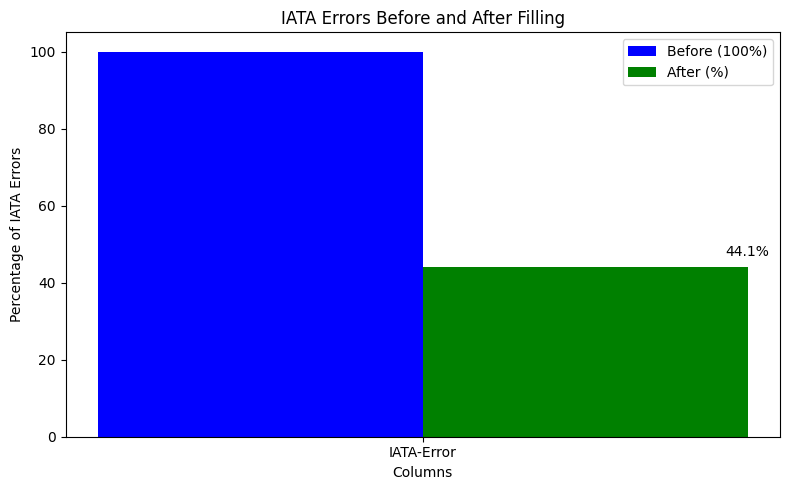

In [108]:
# Plot before filling missing values
missing_before = (error_data_before['IATA-Error'] == 1).sum()

# After filling missing values
missing_after = (error_data_after['IATA-Error'] == 1).sum()

# Plotting
labels = ['IATA-Error']
before_counts = [missing_before]
after_counts = [missing_after]

# Calculate percentage of the After count relative to Before count
percentage_after = [(count / before) * 100 for count, before in zip(after_counts, before_counts)]

x = range(len(labels))

# Plotting
plt.figure(figsize=(8, 5))  # Adjusting figure size
plt.bar(x, [100] * len(before_counts), width=0.4, label='Before (100%)', color='blue', align='center')  # Before as 100%
plt.bar([p + 0.4 for p in x], percentage_after, width=0.4, label='After (%)', color='green', align='center')

plt.xlabel('Columns')
plt.ylabel('Percentage of IATA Errors')
plt.title('IATA Errors Before and After Filling')
plt.xticks([p + 0.2 for p in x], labels)
plt.legend()

# Adding value annotations on the "After" bars
for i in range(len(percentage_after)):
    plt.text(i + 0.6, percentage_after[i] + 2, f'{percentage_after[i]:.1f}%', 
             ha='center', va='bottom', color='black', fontsize=10)

plt.tight_layout()  # Adjust layout to make it look better
plt.show()

In [109]:
# Drop rows containing "NaN" in data_flights Dataframe
t2_data_flights_cleaned = error_data_after[error_data_after['IATA-Error'] != 1]
t2_data_flights_cleaned = t2_data_flights_cleaned.drop('IATA-Error', axis=1)

print(f"Reduced size from {len(error_data_after)} to {len(t2_data_flights_cleaned)}.")

Reduced size from 1882 to 1867.


In [110]:
# Save the updated DataFrame to file
t2_data_flights_cleaned.to_csv('data/t2_FlightData.csv', index=False)  # Replace with your desired output path

## 2.4 Reasoning

IATA-codes are known and publicly available information (e.g., https://github.com/ip2location/ip2location-iata-icao/blob/master/iata-icao.csv).

In order to check for errors, the approach was taken to simply compare each IATA-code of the `data_flights` Dataframe with the above-mentioned list (see function `check_airport_codes()`). Each code (no matter because of which error) that doesn't appear on this list is considered faulty and flagged with the respective column "IATA-Error".

In a second step, the function `solve_iata_error()` checks each flagged row and resolves it by fetching the correct information from the `pyflightdata` function `get_history_by_flight_number(flight_number)`, as similarly done in step 1.

Through this, a significant improvement can be seen: from 34 errors to 15.

For some flights, the ``pyflightapi`` returns a HTTP-402 error indicating that a paid account is required to fetch requested information. To further reduce the amount of flights with NaN-values, such an account would be required. This measure was not taken for this task, and therefore some unique flight-numbers with NaN-values remain. These rows were dropped (see ch. 1.3) to not further interfere with upcoming tasks.

# 3 Derive latitude and longitude- 1 point

In [116]:
# Load your data_flights dataset as DataFrame
data_flights = pd.read_csv('data/t2_FlightData.csv')

# Load airport dataset as DataFrame
airport_data = pd.read_csv('data/iata-icao.csv')

In [117]:
# Initialize new columns with None
data_flights['dep_lat'] = None
data_flights['dep_lon'] = None
data_flights['dest_lat'] = None
data_flights['dest_lon'] = None

In [118]:
def get_lat_long_by_iata(iata_code, df):
    """Retrieve latitude and longitude for a given IATA code."""
    # Filter the DataFrame for the given IATA code
    airport_info = df[df['iata'].str.upper() == iata_code.upper()]

    if not airport_info.empty:
        # Extract latitude and longitude
        latitude = airport_info['latitude'].values[0]
        longitude = airport_info['longitude'].values[0]
        return latitude, longitude
    else:
        return None, None  # Return None if IATA code is not found

In [119]:
# Iterate through the data_flights DataFrame and fill the new columns
for index, row in data_flights.iterrows():
    if pd.isna(row['Departure']) or pd.isna(row['Destination']):
        pass
    else:
        dep_iata = row['Departure']
        dest_iata = row['Destination']
        
        # Get latitude and longitude for the departure IATA code
        dep_lat, dep_long = get_lat_long_by_iata(dep_iata, airport_data)
        data_flights.at[index, 'dep_lat'] = dep_lat
        data_flights.at[index, 'dep_lon'] = dep_long
        
        # Get latitude and longitude for the destination IATA code
        dest_lat, dest_long = get_lat_long_by_iata(dest_iata, airport_data)
        data_flights.at[index, 'dest_lat'] = dest_lat
        data_flights.at[index, 'dest_lon'] = dest_long



In [125]:
# It seems, there are some departure / destination codes which don't appear in the data_airports file provided. 
missing_values = data_flights[['dep_lat', 'dep_lon', 'dest_lat', 'dest_lon']].isna().sum()
print(missing_values)

rows_with_nan = data_flights[data_flights[['dep_lat', 'dep_lon', 'dest_lat', 'dest_lon']].isnull().any(axis=1)]

print(rows_with_nan[['Flight number', 'Departure', 'Destination', 'dep_lat', 'dep_lon', 'dest_lat', 'dest_lon']])

rows_with_dme = data_airports[data_airports['iata'] == 'TFS']
print(rows_with_dme)

dep_lat     5
dep_lon     5
dest_lat    8
dest_lon    8
dtype: int64
     Flight number Departure Destination  dep_lat  dep_lon dest_lat dest_lon
445          EK129       DXB         DME  25.2528  55.3644     None     None
487          EW253       TFS         CGN     None     None  50.8659  7.14274
640         IB3946       MAD         TFN  40.4719 -3.56264     None     None
1357          NH23       HND         ITM  35.5533  139.781     None     None
1358          NH54       CTS         HND     None     None  35.5533  139.781
1359          NH55       HND         CTS  35.5533  139.781     None     None
1363         NH864       GMP         HND     None     None  35.5533  139.781
1364         NT621       SPC         TFN  28.6265 -17.7556     None     None
1418        OZ1055       HND         GMP  35.5533  139.781     None     None
1461        S72507       DME         OVB     None     None  55.0126  82.6507
1561         TC130       DAR         NPY -6.87811  39.2026     None     None
1857   

In [128]:
# Drop rows containing "NaN" in data_flights Dataframe for cols latitude & longitude
columns_to_check = ['dep_lat', 'dep_lon', 'dest_lat', 'dest_lon']
t3_data_flights_cleaned = data_flights.dropna(subset=columns_to_check)

print(f"Number of rows before cleanup: {len(data_flights)}")
print(f"Number of rows after cleanup: {len(t3_data_flights_cleaned)}")

Number of rows before cleanup: 1867
Number of rows after cleanup: 1854


In [127]:
# Save the updated DataFrame
t3_data_flights_cleaned.to_csv('data/t3_FlightData.csv', index=False) 

## 3.1 Reasoning
Four new columns in the `data_flights` Dataframe were created to facilitate the storage of latitude & longitude information for both, departure and destination.

The longitude and latitude data was fetched using the provided `iata-icao.csv` (https://github.com/ip2location/ip2location-iata-icao/blob/master/iata-icao.csv).

It seems `pyflightdata` returns some IATA-codes (5 departures and 8 destinations) which don't appear in `iata-icao.csv`. The assumption taken at this place is, that we take `iata-icao.csv` as the single source of truth, therefore all remaining rows containing NaN for latitude & longitude values (wherever they couldn't be fetched) are dropped to not further interfere with upcoming tasks. This was the case for 13 rows.

# 4 Total distance outlier detection - 3 points

In [175]:
# Setup
data_flights = pd.read_csv('data/t3_FlightData.csv')

## 4.1 Recalculate Air distance with Geopy

In [176]:
from geopy.distance import geodesic, great_circle

data_flights["Air Distance [km]"] = 0      

def calc_air_dist(row):
    if pd.isna(row['dep_lat']) or pd.isna(row['dep_lon']):
        row["Air Distance [km]"] = None
    else:
        dep = (row["dep_lat"], row["dep_lon"])
        dest = (row["dest_lat"], row["dest_lon"])
        try:
            # row["Air Distance [km]"] = round(geodesic(dep, dest).km)
            row["Air Distance [km]"] = round(great_circle(dep, dest).km)
        except:
            row["Air Distance [km]"] = None
    return row


In [171]:
tmp_dist_data_before = data_flights.apply(calc_air_dist, axis=1)

In [177]:
# It seems, there is one flight from ZRH to ZRH with distance 0
missing_before = (tmp_dist_data_before['Air Distance [km]'] == 0).sum()

error_rows = tmp_dist_data_before[tmp_dist_data_before['Air Distance [km]'] == 0]

print(error_rows[['Flight number', 'Departure', 'Destination','Air Distance [km]']])


     Flight number Departure Destination  Air Distance [km]
1023        LX1416       ZRH         ZRH                  0


In [178]:
print(fd.get_history_by_flight_number(error_rows[['Flight number']].values[0][0])[0]["airport"]["origin"]["code"]["iata"])
print(fd.get_history_by_flight_number(error_rows[['Flight number']].values[0][0])[0]["airport"]["destination"]["code"]["iata"])

ZRH
BEG


## 4.1 Visualization of distribution

In [182]:
from geopy.distance import great_circle
#function to calculate the air distance between two points
def calculate_air_distance(row):
    try: 
        lat_dept = data_airports.loc[data_airports['iata'] == row['Departure'], 'latitude'].values[0]
        long_dept = data_airports.loc[data_airports['iata'] == row['Departure'], 'longitude'].values[0]
        lat_dest = data_airports.loc[data_airports['iata'] == row['Destination'], 'latitude'].values[0]
        long_dest = data_airports.loc[data_airports['iata'] == row['Destination'], 'longitude'].values[0]
        return great_circle((lat_dept, long_dept), (lat_dest, long_dest)).kilometers
    except:
        return 'toremove'

IQR: 8991.0
lower_bound used: -13151.5
upper_bound used: 22812.5
Number of outliers detected: 4
Could not recalculate the distance for 0 rows
Number of rows removed due to missing coordinates: 0


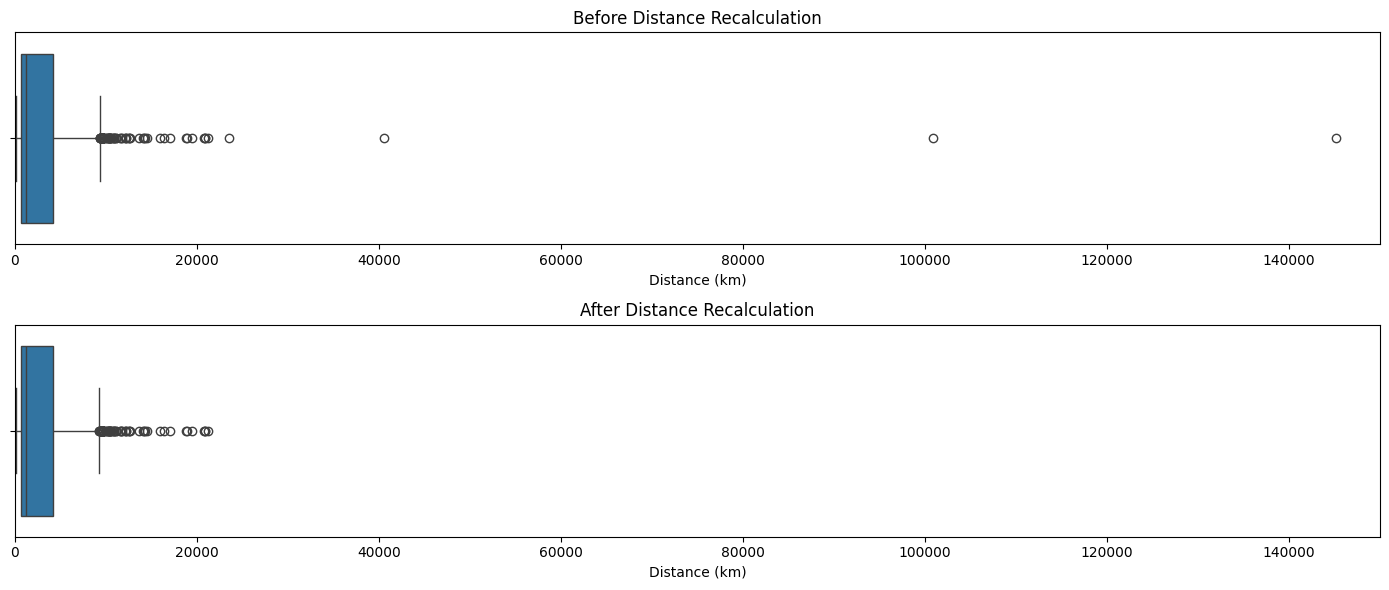


Before distance recalculation:
count      1823.000000
mean       2938.444871
std        5254.167669
min         163.000000
25%         702.000000
50%        1185.000000
75%        4164.000000
max      145129.000000
Name: Total Distance [km], dtype: float64

After distance recalculation :
count     1823.000000
mean      2781.165960
std       3205.718297
min        163.000000
25%        702.000000
50%       1183.000000
75%       4141.000000
max      21274.000000
Name: Total Distance [km], dtype: float64


In [184]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

data_after_long_lat = data_flights

# Ensure the distance column is numeric
data_after_long_lat['Total Distance [km]'] = pd.to_numeric(data_after_long_lat['Total Distance [km]'], errors='coerce')

# Visualize the initial distribution of distances
# plt.figure(figsize=(12, 6))
# sns.histplot(data_after_long_lat['Total Distance [km]'].dropna(), kde=True)
# plt.title('Initial Distribution of Flight Distances')
# plt.xlabel('Distance (km)')
# plt.show()

# Identify outliers using the IQR method
q05 = data_after_long_lat['Total Distance [km]'].quantile(0.05)
q95 = data_after_long_lat['Total Distance [km]'].quantile(0.95)
IQR = q95 - q05
print(f'IQR: {IQR}')
lower_bound = q05 - 1.5 * IQR
upper_bound = q95 + 1.5 * IQR
print(f'lower_bound used: {lower_bound}')
print(f'upper_bound used: {upper_bound}')

outliers = data_after_long_lat[(data_after_long_lat['Total Distance [km]'] < lower_bound) | (data_after_long_lat['Total Distance [km]'] > upper_bound)]
print(f"Number of outliers detected: {len(outliers)}")

# Recalculate distances for outliers
data_recalculated = data_after_long_lat.copy()
outlier_indices = outliers.index
data_recalculated.loc[outlier_indices, 'Total Distance [km]'] = outliers.apply(calculate_air_distance, axis=1)

print(f'Could not recalculate the distance for {len(data_recalculated[data_recalculated["Total Distance [km]"] == "toremove"])} rows')

# Remove rows where distance couldn't be recalculated
data_recalculated = data_recalculated[data_recalculated['Total Distance [km]'] != 'toremove']

print(f"Number of rows removed due to missing coordinates: {len(data_after_long_lat) - len(data_recalculated)}")

# Visualize before and after comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6))


sns.boxplot(x=data_after_long_lat['Total Distance [km]'], ax=ax1)
ax1.set_title('Before Distance Recalculation')
ax1.set_xlabel('Distance (km)')

sns.boxplot(x=data_recalculated['Total Distance [km]'], ax=ax2)
ax2.set_title('After Distance Recalculation')
ax2.set_xlabel('Distance (km)')

ax1.set_xlim(0, 150000)
ax2.set_xlim(0, 150000)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nBefore distance recalculation:")
print(data_after_long_lat['Total Distance [km]'].describe())

print("\nAfter distance recalculation :")
print(data_recalculated['Total Distance [km]'].describe())


# Visualize the distribution
# plt.figure(figsize=(12, 6))
# sns.histplot(data_recalculated['Total Distance [km]'].dropna(), kde=True)
# plt.title('Distribution of Flight Distances After Recalculation')
# plt.xlabel('Distance (km)')
# plt.show()

# References
